In [2]:
import os
import re
import glob
import pickle

import numpy as np
import pandas as pd
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt

from lungmask import mask
from scipy.stats import kruskal
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from scipy.ndimage import zoom
from sklearn.model_selection import StratifiedKFold

import sys
sys.path.append('src')

from data_utils import resize_data

DATA_DIR = "./data"

### Reference data

In [3]:
df_ref = pd.read_excel(os.path.join(DATA_DIR, 'SARP3_20200220m1_SF_LongVD_v3_1.xlsx'))

### Biomarker data

In [28]:
df1 = pd.read_csv(os.path.join(DATA_DIR, 'ct_names.csv'))
df2 = df1.copy()

df2 = df2[~df2['Condition'].isin([4,5])]

df2['Condition'] = df2['Condition'].replace({0: 'Severe decline',
                                             1: 'Mild decline',
                                             2: 'No change',
                                             3: 'Improvement'})

df2['Healthy'] = df2['Healthy'].replace({0: 'Positive',
                                         1: 'Negative'})

df2 = df2.replace(-1, np.nan)
df2 = df2[~df2['ID'].str.contains('V2')]
df2 = df2[~df2['ID'].str.contains('V0')]
df2 = df2[~df2['ID'].str.contains('V3')]
df2['ID'] = df2['ID'].str.replace('-V1', '')
df2 = df2.reset_index(drop=True)

df2['SIN'] = df2['ID'].map(df_ref.set_index('participant')['mhx_1030'])
df2['GERD'] = df2['ID'].map(df_ref.set_index('participant')['rxhx_1620'])
df2['BMI'] = df2['ID'].map(df_ref.set_index('participant')['bmi'])
df2['MRV'] = df2['ID'].map(df_ref.set_index('participant')['mrv_max'])
df2['EOS'] = df2['ID'].map(df_ref.set_index('participant')['eos_count'])
df2['SEX'] = df2['ID'].map(df_ref.set_index('participant')['gender'])
df2['AGE'] = df2['ID'].map(df_ref.set_index('participant')['age_v2'])
df2['TAD'] = df2['ID'].map(df_ref.set_index('participant')['TAdiff_prefev1p'])
df2['LAA'] = df2['ID'].map(df_ref.set_index('participant')['ct_both_pct_below_856_RV1'])
df2['BIO'] = df2['ID'].map(df_ref.set_index('participant')['v6uhx_1520'])


df2 = df2.rename(columns={'SEX': 'GENDER'})

df2['Severity'] = df2['ID'].map(df_ref.set_index('participant')['severity'])
df2['Severity'] = df2['Severity'].replace({0: 'Healthy',
                                           1: 'Mild',
                                           2: 'Moderate',
                                           3: 'Severe'})
df2['SIN'] = df2['SIN'].replace({1: 'Yes',
                                      0: 'No',
                                      8: 'NaN'})
df2['GERD'] = df2['GERD'].replace({1: 'Yes',
                                   0: 'No'})
df2['GENDER'] = df2['GENDER'].replace({2: 'Female',
                                       1: 'Male'})

df2 = df2.rename(columns={'Condition': 'Progression', 'Healthy': 'Group'})

df2 = df2.fillna("Not Found")


df2.to_csv(os.path.join(DATA_DIR, 'severity_LAA.csv'), index=False)

df2.head()

,ID,Progression,Group,SIN,GERD,BMI,MRV,EOS,GENDER,AGE,TAD,LAA,BIO,Severity
0,80-801-005,Improvement,Negative,No,No,22.069861,6.437768,303.0,Female,40.177960,2.859434,7.597856,0.0,Moderate
1,80-801-007,No change,Negative,No,Yes,35.709877,-0.655738,328.0,Female,36.925394,-0.716977,2.593492,Not Found,Moderate
2,80-801-010,No change,Negative,No,No,32.165085,8.754209,162.0,Male,44.796715,-0.201064,4.602292,Not Found,Moderate
3,80-801-011,Severe decline,Positive,No,No,28.196928,20.270270,44.0,Female,43.175907,5.566904,9.50473,1.0,Severe
4,80-801-012,Mild decline,Positive,No,No,29.085873,15.879828,504.0,Female,32.840520,9.113427,1.06985,0.0,Mild


In [6]:
df1 = pd.read_csv(os.path.join(DATA_DIR, 'ct_names.csv'))
df2 = df1.copy()

df2 = df2[~df2['Condition'].isin([4,5])]

df2 = df2.replace(-1, np.nan)
df2 = df2[~df2['ID'].str.contains('V2')]
df2 = df2[~df2['ID'].str.contains('V0')]
df2 = df2[~df2['ID'].str.contains('V3')]
df2['ID'] = df2['ID'].str.replace('-V1', '')
df2 = df2.reset_index(drop=True)

In [7]:
df2

,ID,Condition,Healthy,SIN,GERD,BMI,MRV,EOS,SEX,AGE,TAD
0,80-801-005,3,1,0,0,22,6,303.0,2,40,2.0
1,80-801-007,2,1,0,1,35,0,328.0,2,36,0.0
2,80-801-010,2,1,0,0,32,8,162.0,1,44,0.0
3,80-801-011,0,0,0,0,28,20,44.0,2,43,5.0
4,80-801-012,1,0,0,0,29,15,504.0,2,32,9.0
...,...,...,...,...,...,...,...,...,...,...,...
167,80-841-062,0,0,1,0,28,14,360.0,2,71,3.0
168,80-841-123,3,1,1,1,27,12,1850.0,1,70,40.0
169,80-841-124,3,1,1,1,26,6,324.0,1,62,6.0
170,80-801-104,3,1,0,0,27,33,147.0,1,20,NaN


In [8]:
result = df_ref[df_ref['participant'].isin(df2['ID'])]

In [10]:
result.to_csv("./data/subset.csv", index=False)

### Biomarker distribution

In [29]:
df = pd.read_csv(os.path.join(DATA_DIR, 'severity_LAA.csv'))

df.replace("Not Found", np.nan, inplace=True)

df['EOS'] = pd.to_numeric(df['EOS'], errors='coerce')
df['TAD'] = pd.to_numeric(df['TAD'], errors='coerce')
df['EOS'].fillna(df['EOS'].median(), inplace=True)
df['TAD'].fillna(df['TAD'].median(), inplace=True)
        
df.head()

,ID,Progression,Group,SIN,GERD,BMI,MRV,EOS,GENDER,AGE,TAD,LAA,BIO,Severity
0,80-801-005,Improvement,Negative,No,No,22.069861,6.437768,303.0,Female,40.177960,2.859434,7.597856,0.0,Moderate
1,80-801-007,No change,Negative,No,Yes,35.709877,-0.655738,328.0,Female,36.925394,-0.716977,2.593492,NaN,Moderate
2,80-801-010,No change,Negative,No,No,32.165085,8.754209,162.0,Male,44.796715,-0.201064,4.602292,NaN,Moderate
3,80-801-011,Severe decline,Positive,No,No,28.196928,20.270270,44.0,Female,43.175907,5.566904,9.50473,1.0,Severe
4,80-801-012,Mild decline,Positive,No,No,29.085873,15.879828,504.0,Female,32.840520,9.113427,1.06985,0.0,Mild


In [50]:
print(f'Number of cases: {len(df)}')

progression_counts = df['Progression'].value_counts()
group_counts       = df['Group'].value_counts()
severe_counts      = df['Severity'].value_counts()

print("\nNumber of cases for each progression:")
print(progression_counts)

print("\nNumber of cases for each group:")
print(group_counts)

positive_ratio           = group_counts['Positive'] / group_counts.sum()
print(f"\nPositive ratio = {positive_ratio:.4f}")

Number of cases: 172

Number of cases for each progression:
Improvement       52
No change         51
Mild decline      45
Severe decline    24
Name: Progression, dtype: int64

Number of cases for each group:
Negative    103
Positive     69
Name: Group, dtype: int64

Positive ratio = 0.4012


### Statistic tests

In [51]:
g1 = df.groupby('Progression')['SIN'].agg(count=lambda x: (x == 'Yes').sum(), 
                                          percentage=lambda x: (x == 'Yes').sum() / len(x) * 100)

print("SIN")
print(g1)

contingency = pd.crosstab(df['Progression'], df['SIN'])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"\nChi2 value: {chi2:0.2f}")
print(f"P value:    {p:0.2f}")
print("="*35)

g1 = df.groupby('Group')['SIN'].agg(count=lambda x: (x == 'Yes').sum(), 
                                          percentage=lambda x: (x == 'Yes').sum() / len(x) * 100)

print("SIN")
print(g1)

contingency = pd.crosstab(df['Group'], df['SIN'])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"\nChi2 value: {chi2:0.2f}")
print(f"P value:    {p:0.2f}")
print("="*35)

SIN
                count  percentage
Progression                      
Improvement        17   32.692308
Mild decline       12   26.666667
No change          17   33.333333
Severe decline     13   54.166667

Chi2 value: 6.20
P value:    0.10
SIN
          count  percentage
Group                      
Negative     34   33.009709
Positive     25   36.231884

Chi2 value: 0.09
P value:    0.77


In [52]:
g2 = df.groupby('Progression')['GERD'].agg(count=lambda x: (x == 'Yes').sum(), 
                                           percentage=lambda x: (x == 'Yes').sum() / len(x) * 100)

print("GERD")
print(g2)

contingency = pd.crosstab(df['Progression'], df['GERD'])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"\nChi2 value: {chi2:0.2f}")
print(f"P value:    {p:0.2f}")
print("="*35)

g2 = df.groupby('Group')['GERD'].agg(count=lambda x: (x == 'Yes').sum(), 
                                           percentage=lambda x: (x == 'Yes').sum() / len(x) * 100)

print("GERD")
print(g2)

contingency = pd.crosstab(df['Group'], df['GERD'])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"\nChi2 value: {chi2:0.2f}")
print(f"P value:    {p:0.2f}")
print("="*35)

GERD
                count  percentage
Progression                      
Improvement        19   36.538462
Mild decline       17   37.777778
No change          20   39.215686
Severe decline      9   37.500000

Chi2 value: 0.08
P value:    0.99
GERD
          count  percentage
Group                      
Negative     39   37.864078
Positive     26   37.681159

Chi2 value: 0.00
P value:    1.00


In [53]:
g3 = df.groupby('Progression')['BMI'].agg(
    median='median',
    q25=lambda x: x.quantile(0.25),
    q75=lambda x: x.quantile(0.75)
)

print("BMI")
print(g3)

groups = [df['BMI'][df['Progression'] == group].dropna().tolist() for group in df['Progression'].unique()]
H, p = kruskal(*groups)

print(f"\nH statistic: {H:0.2f}")
print(f"P value: {p:0.2f}")
print("="*35)

g3 = df.groupby('Group')['BMI'].agg(
    median='median',
    q25=lambda x: x.quantile(0.25),
    q75=lambda x: x.quantile(0.75)
)

print("BMI")
print(g3)

groups = [df['BMI'][df['Group'] == group].dropna().tolist() for group in df['Group'].unique()]
H, p = kruskal(*groups)

print(f"\nH statistic: {H:0.2f}")
print(f"P value: {p:0.2f}")
print("="*35)

BMI
                   median        q25        q75
Progression                                    
Improvement     28.353287  25.241622  36.859345
Mild decline    30.554377  27.269284  38.335089
No change       31.287201  26.351254  36.146538
Severe decline  31.933851  28.137583  39.901893

H statistic: 2.66
P value: 0.45
BMI
             median        q25        q75
Group                                    
Negative  29.760666  25.873656  36.565373
Positive  31.184573  27.729719  39.324458

H statistic: 1.65
P value: 0.20


In [54]:
g4 = df.groupby('Progression')['MRV'].agg(
    median='mean',
    std='std'
)

print("MRV")
print(g4)

groups = [df['MRV'][df['Progression'] == group].dropna().tolist() for group in df['Progression'].unique()]
F, p = f_oneway(*groups)

print(f"\nF statistic: {F:0.2f}")
print(f"P value: {p:0.2f}")
print("="*35)

g4 = df.groupby('Group')['MRV'].agg(
    median='mean',
    std='std'
)

print("MRV")
print(g4)

groups = [df['MRV'][df['Group'] == group].dropna().tolist() for group in df['Group'].unique()]
F, p = f_oneway(*groups)

print(f"\nF statistic: {F:0.2f}")
print(f"P value: {p:0.2f}")
print("="*35)

MRV
                   median        std
Progression                         
Improvement     17.118374  16.866106
Mild decline    15.053546  20.518877
No change       15.530592  16.755604
Severe decline  19.042192  11.821680

F statistic: 0.35
P value: 0.79
MRV
             median        std
Group                         
Negative  16.332191  16.747890
Positive  16.440901  17.982174

F statistic: 0.00
P value: 0.97


In [55]:
g5 = df.groupby('Progression')['EOS'].agg(
    median='median',
    q25=lambda x: x.quantile(0.25),
    q75=lambda x: x.quantile(0.75)
)

print("EOS")
print(g5)

groups = [df['EOS'][df['Progression'] == group].dropna().tolist() for group in df['Progression'].unique()]
H, p = kruskal(*groups)

print(f"\nH statistic: {H:0.2f}")
print(f"P value: {p:0.2f}")
print("="*35)

g5 = df.groupby('Group')['EOS'].agg(
    median='median',
    q25=lambda x: x.quantile(0.25),
    q75=lambda x: x.quantile(0.75)
)

print("EOS")
print(g5)

groups = [df['EOS'][df['Group'] == group].dropna().tolist() for group in df['Group'].unique()]
H, p = kruskal(*groups)

print(f"\nH statistic: {H:0.2f}")
print(f"P value: {p:0.2f}")
print("="*35)

EOS
                median    q25      q75
Progression                           
Improvement     244.35  103.5  336.750
Mild decline    180.00  115.0  330.000
No change       222.00  135.4  375.300
Severe decline  165.75   93.9  367.125

H statistic: 0.76
P value: 0.86
EOS
          median    q25    q75
Group                         
Negative   234.0  122.5  355.0
Positive   180.0  111.3  360.0

H statistic: 0.45
P value: 0.50


In [56]:
g6 = df.groupby('Progression')['GENDER'].agg(count=lambda x: (x == 'Female').sum(), 
                                           percentage=lambda x: (x == 'Female').sum() / len(x) * 100)

print("GENDER")
print(g6)

contingency = pd.crosstab(df['Progression'], df['GENDER'])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"\nChi2 value: {chi2:0.2f}")
print(f"P value:    {p:0.2f}")
print("="*35)

g6 = df.groupby('Group')['GENDER'].agg(count=lambda x: (x == 'Female').sum(), 
                                           percentage=lambda x: (x == 'Female').sum() / len(x) * 100)

print("GENDER")
print(g6)

contingency = pd.crosstab(df['Group'], df['GENDER'])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"\nChi2 value: {chi2:0.2f}")
print(f"P value:    {p:0.2f}")
print("="*35)

GENDER
                count  percentage
Progression                      
Improvement        35   67.307692
Mild decline       30   66.666667
No change          30   58.823529
Severe decline     19   79.166667

Chi2 value: 3.08
P value:    0.38
GENDER
          count  percentage
Group                      
Negative     65   63.106796
Positive     49   71.014493

Chi2 value: 0.83
P value:    0.36


In [57]:
g7 = df.groupby('Progression')['AGE'].agg(
    median='mean',
    std='std'
)

print("AGE")
print(g7)

groups = [df['AGE'][df['Progression'] == group].dropna().tolist() for group in df['Progression'].unique()]
F, p = f_oneway(*groups)

print(f"\nF statistic: {F:0.2f}")
print(f"P value: {p:0.2f}")
print("="*35)

g7 = df.groupby('Group')['AGE'].agg(
    median='mean',
    std='std'
)

print("AGE")
print(g7)

groups = [df['AGE'][df['Group'] == group].dropna().tolist() for group in df['Group'].unique()]
F, p = f_oneway(*groups)

print(f"\nF statistic: {F:0.2f}")
print(f"P value: {p:0.2f}")
print("="*35)

AGE
                   median        std
Progression                         
Improvement     44.564313  15.376787
Mild decline    46.484569  14.779187
No change       45.512045  14.559347
Severe decline  47.996920  14.378900

F statistic: 0.33
P value: 0.80
AGE
             median        std
Group                         
Negative  45.033579  14.911695
Positive  47.010604  14.553040

F statistic: 0.74
P value: 0.39


In [58]:
g8 = df.groupby('Progression')['TAD'].agg(
    median='mean',
    std='std'
)

print("TAD")
print(g8)

groups = [df['TAD'][df['Progression'] == group].dropna().tolist() for group in df['Progression'].unique()]
F, p = f_oneway(*groups)

print(f"\nF statistic: {F:0.2f}")
print(f"P value: {p:0.2f}")
print("="*35)

g8 = df.groupby('Group')['TAD'].agg(
    median='mean',
    std='std'
)

print("TAD")
print(g8)

groups = [df['TAD'][df['Group'] == group].dropna().tolist() for group in df['Group'].unique()]
F, p = f_oneway(*groups)

print(f"\nF statistic: {F:0.2f}")
print(f"P value: {p:0.2f}")
print("="*35)

TAD
                  median        std
Progression                        
Improvement     5.616529   8.339714
Mild decline    2.482676   5.786331
No change       0.459408   7.566112
Severe decline  2.795408  11.024482

F statistic: 3.65
P value: 0.01
TAD
            median       std
Group                       
Negative  3.063003  8.339709
Positive  2.591452  7.924389

F statistic: 0.14
P value: 0.71


### Example CT scan masking

In [10]:
test_load = sitk.ReadImage(os.path.join(DATA_DIR, '80-801-007-V1.nii'))
segmentation = mask.apply(test_load)

Downloading: "https://github.com/JoHof/lungmask/releases/download/v0.0/unet_r231-d5d2fc3d.pth" to /Users/sj0161/.cache/torch/hub/checkpoints/unet_r231-d5d2fc3d.pth
100%|██████████| 119M/119M [00:03<00:00, 39.2MB/s] 


lungmask 2024-02-11 16:16:09 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


34it [00:16,  2.03it/s]                          

lungmask 2024-02-11 16:16:32 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 229.36it/s]


In [11]:
segmentation.shape

(666, 512, 512)

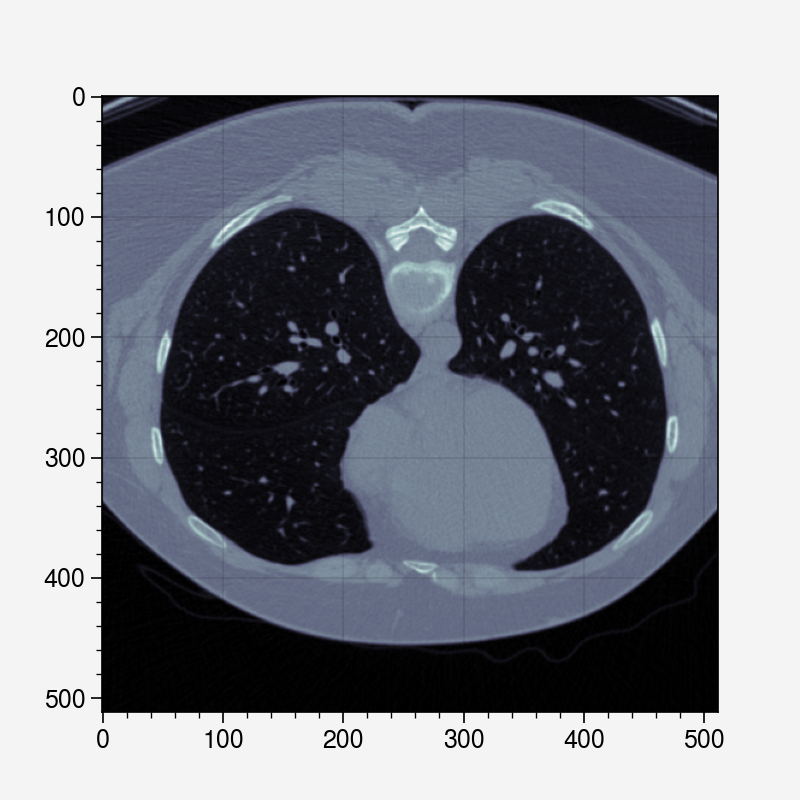

In [29]:
img = sitk.GetArrayFromImage(test_load)

fig, ax = plt.subplots()
ax.imshow(img[256, ...], cmap='bone');

In [30]:
masked = np.copy(img)
masked[segmentation == 0] = 1024 # maximum 1000, minimum -1000
masked = masked / 2048 + 0.5 # normalize between 0 and 1
masked = masked.astype(np.float32)

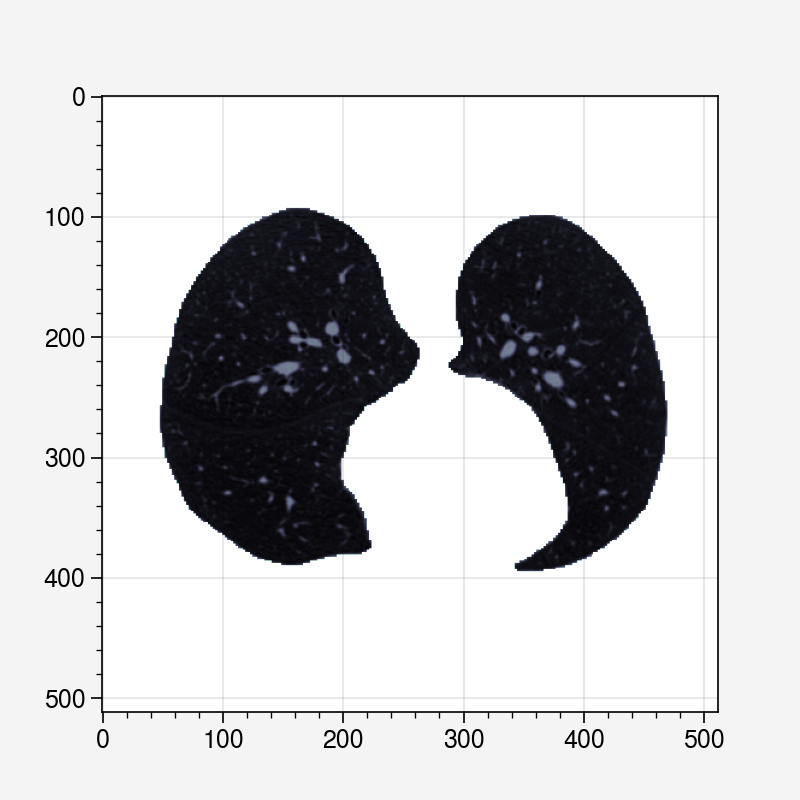

In [31]:
fig, ax = plt.subplots()
ax.imshow(masked[256, ...], cmap='bone');

### Prepare 5-fold indices for CT scans

In [62]:
# all ct scans, some don't have biomarkers, so have to remove these instances
f = []

for i in range(5):
    f += glob.glob(os.path.join(DATA_DIR, 'data_seg/*V1_*_{i}_*.pickle'))

files = np.array(sorted(f))

# each files contains data of size (n_slices*512*512)

In [65]:
def extract_id(filepath):
    match = re.search(r'seg_(\d+-\d+-\d+)-', filepath)
    return match.group(1) if match else None

ids = [extract_id(fp) for fp in files]

matched_df = df[df['ID'].isin(ids)]

not_found_ids = set(ids) - set(df['ID'].unique())

In [70]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_file = []
fold_progression = []
fold_group = []

for fold, (train_idx, test_idx) in enumerate(skf.split(matched_df, matched_df['Progression'])):
    skf2 = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    
    test_id = matched_df['ID'].iloc[test_idx].tolist()
    test_progression = matched_df['Progression'].iloc[test_idx].tolist()
    test_group = matched_df['Group'].iloc[test_idx].tolist()
    test_files = [f for f in files if any(name in f for name in test_id)]
    
    train_data = matched_df.iloc[train_idx]
    for train_split_idx, val_split_idx in skf.split(train_data, train_data['Progression']):
        train_split = train_data.iloc[train_split_idx]
        val_split = train_data.iloc[val_split_idx]
    
        train_id = train_data['ID'].iloc[train_split_idx].tolist()
        train_progression = train_data['Progression'].iloc[train_split_idx].tolist()
        train_group = train_data['Group'].iloc[train_split_idx].tolist()
        train_files = [f for f in files if any(name in f for name in train_id)]
    
        valid_id = train_data['ID'].iloc[val_split_idx].tolist()
        valid_progression = train_data['Progression'].iloc[val_split_idx].tolist()
        valid_group = train_data['Group'].iloc[val_split_idx].tolist()
        valid_files = [f for f in files if any(name in f for name in valid_id)]
        
        break
    
    fold_file.append([train_files, valid_files, test_files])
    fold_progression.append([train_progression, valid_progression, test_progression])
    fold_group.append([train_group, valid_group, test_group])
    
with open(os.path.join(DATA_DIR, 'five_fold.pickle'), 'wb') as handle:
    pickle.dump(fold_file, handle)
    pickle.dump(fold_group, handle)
    pickle.dump(fold_progression, handle)

### CT scan statistics

In [73]:
with open(os.path.join(DATA_DIR, 'five_fold.pickle'), 'rb') as handle:
    fold_file = pickle.load(handle)
    fold_group = pickle.load(handle)
    fold_progression = pickle.load(handle)

In [75]:
f = []

for i in range(5):
    f += glob.glob(os.path.join(DATA_DIR, 'data_seg/*V1_*_{i}_*.pickle'))

files = np.array(sorted(f))

s_max = np.max([int(files[i].split("_")[-3]) for i in range(len(files))])
s_min = np.min([int(files[i].split("_")[-3]) for i in range(len(files))])

print(f"Max Number of Slices: {s_max}")
print(f"Min Number of Slices: {s_min}")

Max Number of Slices: 713
Min Number of Slices: 201


In [76]:
with open(os.path.join(DATA_DIR, 'five_fold.pickle'), 'rb') as handle:
    fold_file = pickle.load(handle)
    
fold_file = fold_file[0]

file = [item for sublist in fold_file for item in sublist]
print(f"Dataset Size: {len(file)}")

Dataset Size: 172


### Zoom 3d CT scans into lower resolution

In [81]:
resize_data(data_dir=DATA_DIR, 
            input_size=(713, 512, 512), 
            file_paths=file, 
            zoom_ratio=0.125)

In [82]:
resize_data(data_dir=DATA_DIR, 
            input_size=(713, 512, 512), 
            file_paths=file, 
            zoom_ratio=0.25)

In [83]:
resize_data(data_dir=DATA_DIR, 
            input_size=(713, 512, 512), 
            file_paths=file, 
            zoom_ratio=0.5)